# Dependencies and Reading Raw Data

In [1]:
import pandas as pd
import sklearn
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Raw Data 
astro_df = pd.read_csv('Skyserver_2019.csv')
astro_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42
3,1237665441518260000,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121,2254061292459420000,GALAXY,0.058155,2002,53471,35
4,1237665441522840000,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191,2390305906828010000,GALAXY,0.072210,2123,53793,74


In [3]:
# Removing useless columns for ML analysis.
astro_df = astro_df[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']]

# Separating Training and Test Data

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(astro_df, test_size=0.2, random_state=42)

# Stratifying Data Based on Redshift (assumption that redshift is important!)

<AxesSubplot:>

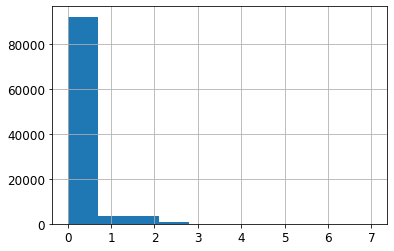

In [5]:
astro_df['redshift'].hist()

In [6]:
astro_df["redshift_cat"] = pd.cut(astro_df["redshift"],
                               bins=[-1, 0., .5, 1.0, 1.5, 2.0, 2.5, np.inf],
                               labels=[-1, 0, 1, 2, 3, 4, 5])

In [7]:
astro_df['redshift_cat'].value_counts()

0     66391
-1    24938
2      2825
3      2464
1      2071
4      1011
5       300
Name: redshift_cat, dtype: int64

<AxesSubplot:>

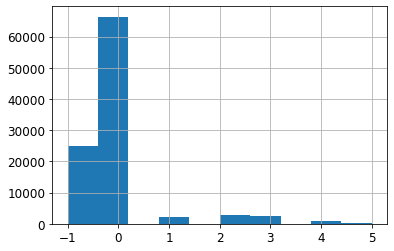

In [8]:
astro_df['redshift_cat'].hist()

In [9]:
# Using Sklearn's Statify Method 

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(astro_df, astro_df['redshift_cat']):
    
    strat_train_set = astro_df.loc[train_index]
    strat_test_set = astro_df.loc[test_index]

In [10]:
# Now that we have stratified our data based on redshift vales, we can drop the redshift category column.
strat_train_set.drop(['redshift_cat'], axis=1, inplace=True)
strat_test_set.drop(['redshift_cat'], axis=1, inplace=True)

# Data Cleaning and Preperation for ML Algorithms

In [11]:
# Separating Independant from Dependant Variables
astro_data = strat_train_set.drop("class", axis=1) # X
astro_labels = strat_train_set["class"] # Y

In [12]:
# from sklearn.preprocessing import LabelEncoder

# cat_encoder = LabelEncoder()
# astro_labels = cat_encoder.fit_transform(astro_labels)
# astro_labels

In [13]:
# Will have to One Hot Encode the Dependant var
# from sklearn.preprocessing import OneHotEncoder

# cat_encoder = OneHotEncoder()
# astro_cat_1hot = cat_encoder.fit_transform(astro_labels.reshape(-1,1))
# astro_cat_1hot

In [14]:
# Will use Standardized Scaler for Independant vars
from sklearn.preprocessing import StandardScaler

astro_data_scaled = StandardScaler().fit_transform(astro_data)

# Models

# SGD Classifier

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(astro_data_scaled, astro_labels)

SGDClassifier(random_state=42)

In [16]:
# Score on the trained dataset 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, astro_data_scaled, astro_labels, cv=3, scoring="accuracy")

array([0.95818802, 0.95458807, 0.95653641])

In [17]:
# Looking at the Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_classifier, astro_data_scaled, astro_labels, cv=3)

labels = np.unique(y_train_pred)

cm = confusion_matrix(astro_labels, y_train_pred)
cm



array([[39485,   159,  1387],
       [ 1259,  7214,     5],
       [  661,    14, 29816]], dtype=int64)

In [18]:
pd.DataFrame(cm, index=labels, columns=labels)

,GALAXY,QSO,STAR
GALAXY,39485,159,1387
QSO,1259,7214,5
STAR,661,14,29816


In [19]:
from sklearn.metrics import f1_score

f1_score(astro_labels, y_train_pred, average='micro')

0.9564375

In [20]:
from sklearn.model_selection import GridSearchCV

grid = {
    'max_iter': [1000],
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'eta0': [0, 0.1]
}

grid_search = GridSearchCV(sgd_classifier, grid, cv=5, verbose=3)
# grid_search.fit(astro_data_scaled, astro_labels)
#grid_search.best_params_

In [21]:
y_train_pred = cross_val_predict(grid_search, astro_data_scaled, astro_labels, cv=3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.966, total=   0.1s
[CV] eta0=0, max_iter=1000, penalty=None .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . eta0=0, max_iter=1000, penalty=None, score=0.969, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.970, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s



[CV] . eta0=0, max_iter=1000, penalty=None, score=0.970, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.969, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.954, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.956, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.961, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.955, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.958, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l1 ...............................
[CV] 

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.0s finished



[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.969, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . eta0=0, max_iter=1000, penalty=None, score=0.968, total=   0.1s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.969, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] . eta0=0, max_iter=1000, penalty=None, score=0.969, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.969, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.958, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.956, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.957, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.955, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.959, total=   0.1s
[CV] eta0=0, max_iter=1000, penalty=l1 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    7.7s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] eta0=0, max_iter=1000, penalty=None .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . eta0=0, max_iter=1000, penalty=None, score=0.970, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.977, total=   0.3s
[CV] eta0=0, max_iter=1000, penalty=None .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] . eta0=0, max_iter=1000, penalty=None, score=0.970, total=   0.3s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.970, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=None .............................
[CV] . eta0=0, max_iter=1000, penalty=None, score=0.968, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.958, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.956, total=   0.1s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.953, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] ... eta0=0, max_iter=1000, penalty=l2, score=0.956, total=   0.2s
[CV] eta0=0, max_iter=1000, penalty=l2 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.2s finished


In [22]:
cm = confusion_matrix(astro_labels, y_train_pred)

In [23]:
# Better f1 score
f1_score(astro_labels, y_train_pred, average='micro')

0.9682375

In [24]:
# Better Confusion Matrix With Hyper Tuned Parameters

labels = np.unique(y_train_pred)
pd.DataFrame(cm, index=labels, columns=labels)

,GALAXY,QSO,STAR
GALAXY,40318,291,422
QSO,1261,7213,4
STAR,554,9,29928


# Random Forrest Classifier






In [25]:
from sklearn.preprocessing import LabelEncoder

cat_encoder = LabelEncoder()
astro_labels = cat_encoder.fit_transform(astro_labels)
astro_labels

array([2, 2, 0, ..., 0, 0, 0])

In [26]:
cat_encoder.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(astro_data_scaled, astro_labels)

RandomForestClassifier(random_state=42)

In [28]:
astro_predictions = forest_clf.predict(astro_data_scaled)

In [29]:
astro_predictions

array([2, 2, 0, ..., 0, 0, 0])

In [31]:
f1_score(astro_labels, astro_predictions, average='micro')

1.0

In [32]:
confusion_matrix(astro_labels, astro_predictions)

array([[41031,     0,     0],
       [    0,  8478,     0],
       [    0,     0, 30491]], dtype=int64)

In [36]:
cat_encoder.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

# Using The Test Data

In [33]:
# Testing the Test data 
x_test = strat_test_set.drop("class", axis=1)
x_test_scaled = StandardScaler().fit_transform(x_test)
y_test = strat_test_set["class"]

In [37]:
predictions = forest_clf.predict(x_test_scaled)

In [38]:
predictions = cat_encoder.inverse_transform(predictions)

In [39]:
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['STAR' 'STAR' 'GALAXY' 'QSO' 'GALAXY' 'GALAXY' 'GALAXY' 'STAR' 'GALAXY'
 'GALAXY']
First 10 Actual labels: ['STAR', 'STAR', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY']


In [43]:
check_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
check_df.head(60)

,Prediction,Actual
0,STAR,STAR
1,STAR,STAR
2,GALAXY,GALAXY
3,QSO,QSO
4,GALAXY,GALAXY
5,GALAXY,GALAXY
6,GALAXY,GALAXY
7,STAR,STAR
8,GALAXY,GALAXY
9,GALAXY,GALAXY


In [42]:
f1_score(y_test, predictions, average='micro')

0.9879